Video boyutu: 1920x1080, FPS: 23.976023976023978, Toplam kare: 447
Video süresi: 18.64 saniye
Video işleniyor...
İşlenen kare: 20/447
İşlenen kare: 40/447
İşlenen kare: 60/447
İşlenen kare: 80/447
İşlenen kare: 100/447
İşlenen kare: 120/447
İşlenen kare: 140/447
İşlenen kare: 160/447
İşlenen kare: 180/447
İşlenen kare: 200/447
İşlenen kare: 220/447
İşlenen kare: 240/447
İşlenen kare: 260/447
İşlenen kare: 280/447
İşlenen kare: 300/447
İşlenen kare: 320/447
İşlenen kare: 340/447
İşlenen kare: 360/447
İşlenen kare: 380/447
İşlenen kare: 400/447
İşlenen kare: 420/447
İşlenen kare: 440/447
Video işleme tamamlandı.
Spagetti diyagramı oluşturuluyor...
Spagetti diyagramı kaydedildi: insaat_spaghetti_diagram.png

İşçi 1 (Sol) İş Adımları:
  Adım 1: 0.42s - 7.34s (Süre: 6.92s)
  Toplam aktif süre: 6.92s
  Verimlilik oranı: 37.22%

İşçi 2 (Orta) İş Adımları:
  Adım 1: 0.83s - 2.00s (Süre: 1.17s)
  Adım 2: 2.17s - 7.34s (Süre: 5.17s)
  Toplam aktif süre: 6.34s
  Verimlilik oranı: 34.08%

İşçi 3 (

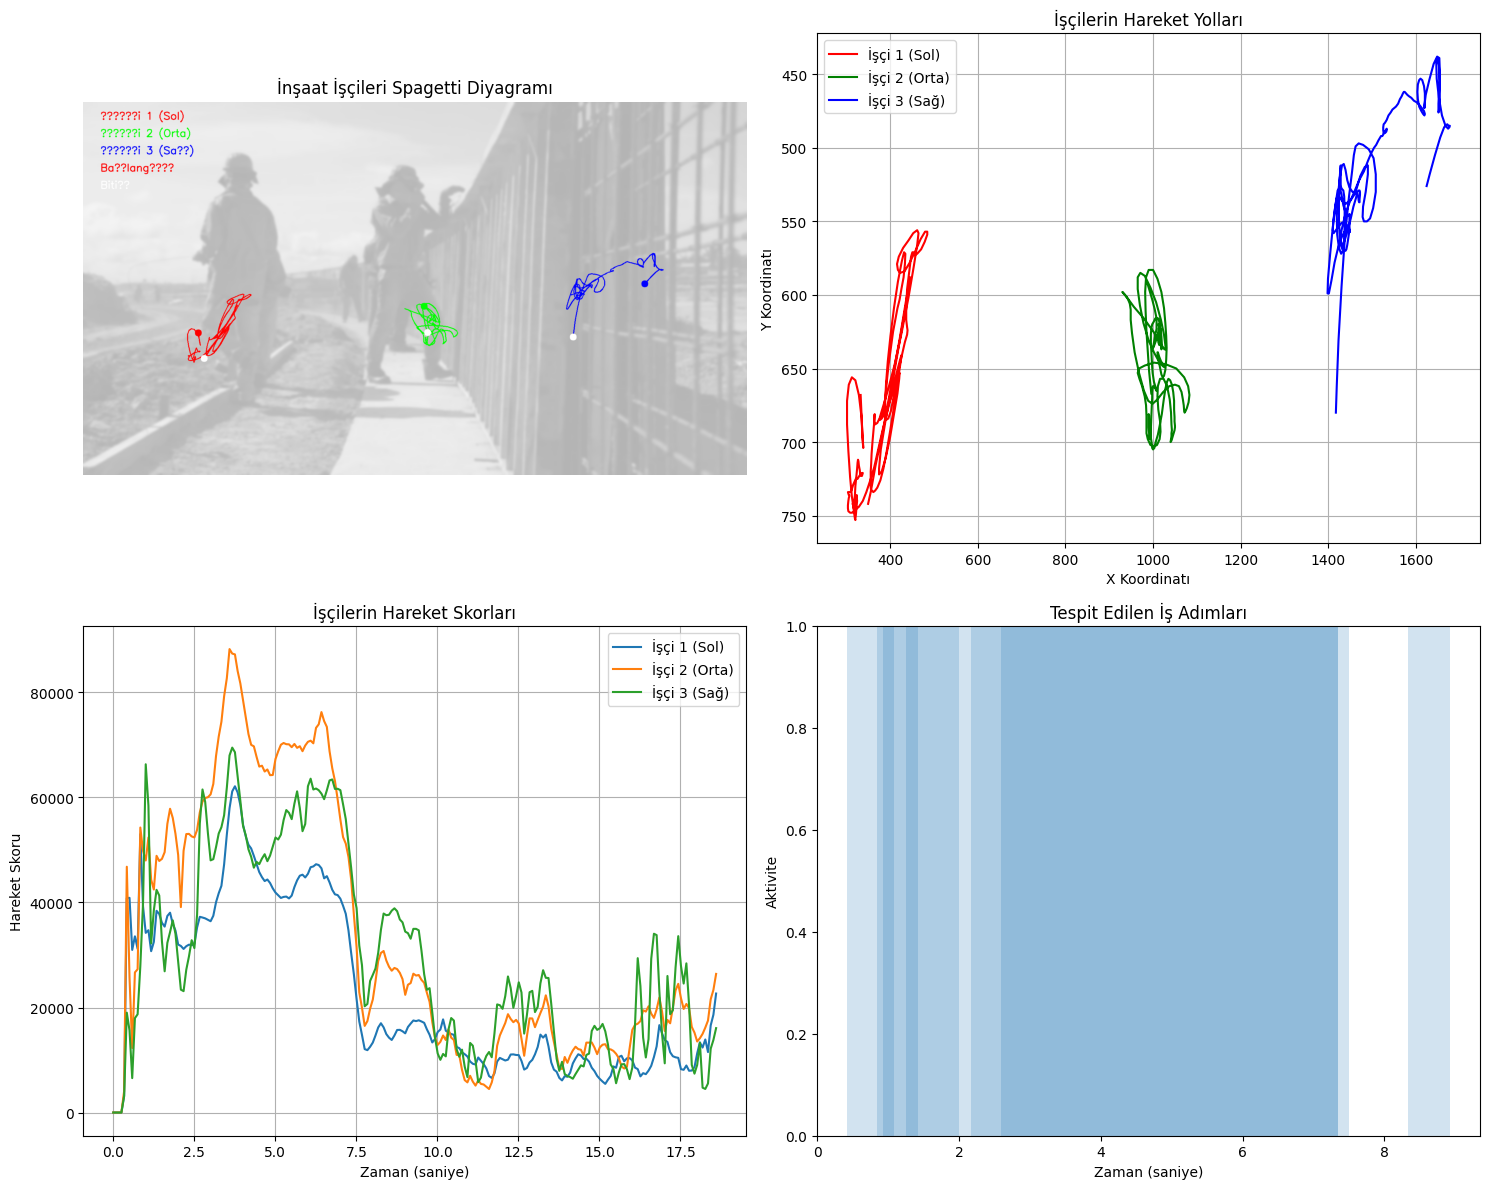


Hareket Analizi:
İşçi 1 (Sol) toplam hareket mesafesi: 1906.06 piksel
İşçi 2 (Orta) toplam hareket mesafesi: 1465.60 piksel
İşçi 3 (Sağ) toplam hareket mesafesi: 1581.33 piksel

Toplam hareket mesafesi: 4952.99 piksel
İşçi 1 hareket oranı: 38.48%
İşçi 2 hareket oranı: 29.59%
İşçi 3 hareket oranı: 31.93%

Isı haritası oluşturuluyor...
Isı haritası kaydedildi: insaat_heatmap.png


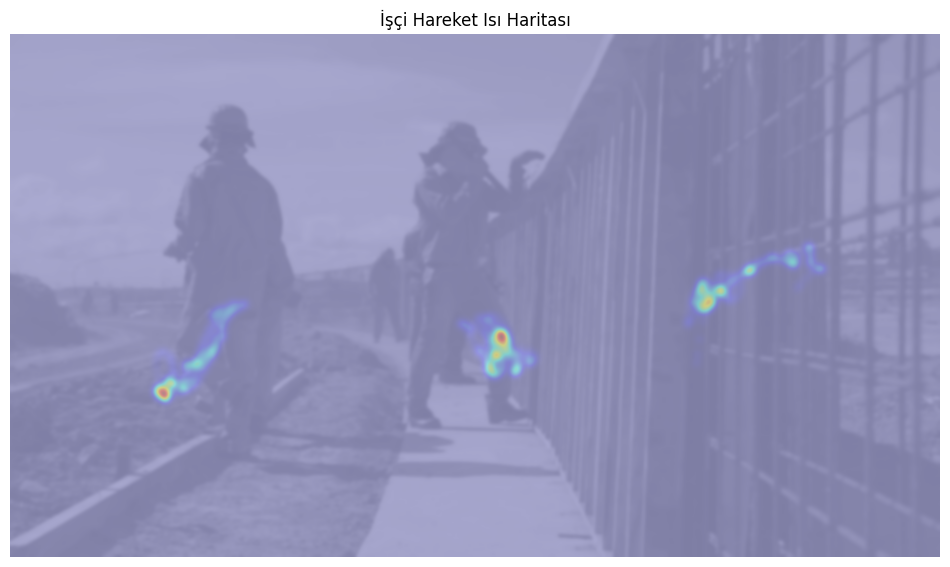


Hareket animasyonu oluşturuluyor...
Hareket animasyonu kaydedildi: insaat_spaghetti_animation.mp4

İşlenmiş video oluşturuluyor...
İşlenmiş video kaydedildi: insaat_analiz_video.mp4

Tüm analizler tamamlandı.


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import time

# Video dosyasını aç
cap = cv2.VideoCapture('deneme.mp4')
if not cap.isOpened():
    raise IOError("Video açılamadı!")

# Video özellikleri
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(f"Video boyutu: {width}x{height}, FPS: {fps}, Toplam kare: {frame_count}")
print(f"Video süresi: {frame_count/fps:.2f} saniye")

# İlk kareyi al ve arka plan olarak kullan
ret, first_frame = cap.read()
if not ret:
    raise IOError("İlk kare okunamadı!")

# Arka plan görüntüsü oluştur (ilk kareyi gri tonlama ve hafif bulanıklaştır)
background = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
background = cv2.GaussianBlur(background, (21, 21), 0)
background = cv2.cvtColor(background, cv2.COLOR_GRAY2BGR)
background = cv2.addWeighted(background, 0.3, np.ones_like(background)*255, 0.7, 0)

# Spagetti diyagramı için boş görüntü
spaghetti_diagram = background.copy()

# İnşaat işçileri için bölgeler (sol, orta, sağ)
worker1_roi = (0, 0, width//3, height)  # x, y, w, h - Sol işçi
worker2_roi = (width//3, 0, width//3, height)  # x, y, w, h - Orta işçi
worker3_roi = (2*width//3, 0, width//3, height)  # x, y, w, h - Sağ işçi

# İşçi izleme için değişkenler
worker1_positions = []
worker2_positions = []
worker3_positions = []
frame_indices = []

# Hareket tespiti için arka plan çıkarıcı
fgbg = cv2.createBackgroundSubtractorMOG2(history=50, varThreshold=25, detectShadows=True)

# Video başına dön
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Her kareyi işle
frame_idx = 0
sample_interval = 2  # Her 2 karede bir örnek al

print("Video işleniyor...")

# Hareket analizi için değişkenler
motion_scores = {
    "İşçi 1 (Sol)": [],
    "İşçi 2 (Orta)": [],
    "İşçi 3 (Sağ)": []
}
frame_times = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    if frame_idx % sample_interval == 0:
        # Ön plan maskesi
        fgmask = fgbg.apply(frame)

        # İşçi 1 bölgesi için maske
        x1, y1, w1, h1 = worker1_roi
        worker1_mask = fgmask[y1:y1+h1, x1:x1+w1]

        # İşçi 2 bölgesi için maske
        x2, y2, w2, h2 = worker2_roi
        worker2_mask = fgmask[y2:y2+h2, x2:x2+w2]

        # İşçi 3 bölgesi için maske
        x3, y3, w3, h3 = worker3_roi
        worker3_mask = fgmask[y3:y3+h3, x3:x3+w3]

        # İşçi 1 için merkez nokta bul
        if np.sum(worker1_mask) > 100:  # Eşik değeri
            M = cv2.moments(worker1_mask)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"]) + x1
                cy = int(M["m01"] / M["m00"]) + y1
                worker1_positions.append((cx, cy))
            else:
                # Eğer moment hesaplanamazsa, bölgenin ortasını al
                worker1_positions.append((x1 + w1//2, y1 + h1//2))
        else:
            # Hareket yoksa son pozisyonu koru
            if worker1_positions:
                worker1_positions.append(worker1_positions[-1])
            else:
                worker1_positions.append((x1 + w1//2, y1 + h1//2))

        # İşçi 2 için merkez nokta bul
        if np.sum(worker2_mask) > 100:  # Eşik değeri
            M = cv2.moments(worker2_mask)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"]) + x2
                cy = int(M["m01"] / M["m00"]) + y2
                worker2_positions.append((cx, cy))
            else:
                # Eğer moment hesaplanamazsa, bölgenin ortasını al
                worker2_positions.append((x2 + w2//2, y2 + h2//2))
        else:
            # Hareket yoksa son pozisyonu koru
            if worker2_positions:
                worker2_positions.append(worker2_positions[-1])
            else:
                worker2_positions.append((x2 + w2//2, y2 + h2//2))

        # İşçi 3 için merkez nokta bul
        if np.sum(worker3_mask) > 100:  # Eşik değeri
            M = cv2.moments(worker3_mask)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"]) + x3
                cy = int(M["m01"] / M["m00"]) + y3
                worker3_positions.append((cx, cy))
            else:
                # Eğer moment hesaplanamazsa, bölgenin ortasını al
                worker3_positions.append((x3 + w3//2, y3 + h3//2))
        else:
            # Hareket yoksa son pozisyonu koru
            if worker3_positions:
                worker3_positions.append(worker3_positions[-1])
            else:
                worker3_positions.append((x3 + w3//2, y3 + h3//2))

        # Hareket skorlarını kaydet
        motion_scores["İşçi 1 (Sol)"].append(np.sum(worker1_mask == 255))
        motion_scores["İşçi 2 (Orta)"].append(np.sum(worker2_mask == 255))
        motion_scores["İşçi 3 (Sağ)"].append(np.sum(worker3_mask == 255))

        # Zaman bilgisini kaydet
        frame_times.append(frame_idx / fps)
        frame_indices.append(frame_idx)

    frame_idx += 1
    if frame_idx % 20 == 0:
        print(f"İşlenen kare: {frame_idx}/{frame_count}")

cap.release()
print("Video işleme tamamlandı.")

# Pozisyonları düzgünleştir (gürültüyü azalt)
worker1_positions_array = np.array(worker1_positions)
worker2_positions_array = np.array(worker2_positions)
worker3_positions_array = np.array(worker3_positions)

# Gaussian smoothing
worker1_x_smooth = gaussian_filter1d(worker1_positions_array[:, 0], sigma=2)
worker1_y_smooth = gaussian_filter1d(worker1_positions_array[:, 1], sigma=2)
worker2_x_smooth = gaussian_filter1d(worker2_positions_array[:, 0], sigma=2)
worker2_y_smooth = gaussian_filter1d(worker2_positions_array[:, 1], sigma=2)
worker3_x_smooth = gaussian_filter1d(worker3_positions_array[:, 0], sigma=2)
worker3_y_smooth = gaussian_filter1d(worker3_positions_array[:, 1], sigma=2)

worker1_positions_smooth = list(zip(worker1_x_smooth, worker1_y_smooth))
worker2_positions_smooth = list(zip(worker2_x_smooth, worker2_y_smooth))
worker3_positions_smooth = list(zip(worker3_x_smooth, worker3_y_smooth))

# Spagetti diyagramı çiz
print("Spagetti diyagramı oluşturuluyor...")

# İşçi 1 için yolu çiz (kırmızı)
for i in range(1, len(worker1_positions_smooth)):
    start_point = (int(worker1_positions_smooth[i-1][0]), int(worker1_positions_smooth[i-1][1]))
    end_point = (int(worker1_positions_smooth[i][0]), int(worker1_positions_smooth[i][1]))
    cv2.line(spaghetti_diagram, start_point, end_point, (0, 0, 255), 2)

# İşçi 2 için yolu çiz (yeşil)
for i in range(1, len(worker2_positions_smooth)):
    start_point = (int(worker2_positions_smooth[i-1][0]), int(worker2_positions_smooth[i-1][1]))
    end_point = (int(worker2_positions_smooth[i][0]), int(worker2_positions_smooth[i][1]))
    cv2.line(spaghetti_diagram, start_point, end_point, (0, 255, 0), 2)

# İşçi 3 için yolu çiz (mavi)
for i in range(1, len(worker3_positions_smooth)):
    start_point = (int(worker3_positions_smooth[i-1][0]), int(worker3_positions_smooth[i-1][1]))
    end_point = (int(worker3_positions_smooth[i][0]), int(worker3_positions_smooth[i][1]))
    cv2.line(spaghetti_diagram, start_point, end_point, (255, 0, 0), 2)

# Başlangıç ve bitiş noktalarını işaretle
cv2.circle(spaghetti_diagram, (int(worker1_positions_smooth[0][0]), int(worker1_positions_smooth[0][1])), 10, (0, 0, 255), -1)
cv2.circle(spaghetti_diagram, (int(worker1_positions_smooth[-1][0]), int(worker1_positions_smooth[-1][1])), 10, (255, 255, 255), -1)
cv2.circle(spaghetti_diagram, (int(worker2_positions_smooth[0][0]), int(worker2_positions_smooth[0][1])), 10, (0, 255, 0), -1)
cv2.circle(spaghetti_diagram, (int(worker2_positions_smooth[-1][0]), int(worker2_positions_smooth[-1][1])), 10, (255, 255, 255), -1)
cv2.circle(spaghetti_diagram, (int(worker3_positions_smooth[0][0]), int(worker3_positions_smooth[0][1])), 10, (255, 0, 0), -1)
cv2.circle(spaghetti_diagram, (int(worker3_positions_smooth[-1][0]), int(worker3_positions_smooth[-1][1])), 10, (255, 255, 255), -1)

# Lejant ekle
cv2.putText(spaghetti_diagram, "İşçi 1 (Sol)", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
cv2.putText(spaghetti_diagram, "İşçi 2 (Orta)", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
cv2.putText(spaghetti_diagram, "İşçi 3 (Sağ)", (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
cv2.putText(spaghetti_diagram, "Başlangıç", (50, 200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
cv2.putText(spaghetti_diagram, "Bitiş", (50, 250), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

# Spagetti diyagramını kaydet
cv2.imwrite("insaat_spaghetti_diagram.png", spaghetti_diagram)
print("Spagetti diyagramı kaydedildi: insaat_spaghetti_diagram.png")

# Matplotlib ile göster
plt.figure(figsize=(15, 12))

# Spagetti diyagramı
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(spaghetti_diagram, cv2.COLOR_BGR2RGB))
plt.title('İnşaat İşçileri Spagetti Diyagramı')
plt.axis('off')

# Hareket yolları grafiği
plt.subplot(2, 2, 2)
plt.plot(worker1_x_smooth, worker1_y_smooth, 'r-', label='İşçi 1 (Sol)')
plt.plot(worker2_x_smooth, worker2_y_smooth, 'g-', label='İşçi 2 (Orta)')
plt.plot(worker3_x_smooth, worker3_y_smooth, 'b-', label='İşçi 3 (Sağ)')
plt.gca().invert_yaxis()  # Y ekseni yukarıdan aşağıya
plt.title('İşçilerin Hareket Yolları')
plt.xlabel('X Koordinatı')
plt.ylabel('Y Koordinatı')
plt.legend()
plt.grid(True)

# Hareket skorları grafiği
plt.subplot(2, 2, 3)
for worker_name, scores in motion_scores.items():
    plt.plot(frame_times, scores, label=worker_name)
plt.title('İşçilerin Hareket Skorları')
plt.xlabel('Zaman (saniye)')
plt.ylabel('Hareket Skoru')
plt.legend()
plt.grid(True)

# İş adımlarını tespit et
plt.subplot(2, 2, 4)
for worker_name, scores in motion_scores.items():
    threshold = np.mean(scores) * 1.2
    high_motion_periods = []
    current_period = None

    for i, score in enumerate(scores):
        if score > threshold and current_period is None:
            current_period = {'start': frame_times[i], 'end': frame_times[i]}
        elif score > threshold and current_period is not None:
            current_period['end'] = frame_times[i]
        elif score <= threshold and current_period is not None:
            if current_period['end'] - current_period['start'] >= 0.1:
                high_motion_periods.append(current_period)
            current_period = None

    # Son periyodu ekle
    if current_period is not None and current_period['end'] - current_period['start'] >= 0.1:
        high_motion_periods.append(current_period)

    # Grafik üzerinde yüksek hareket dönemlerini göster
    for period in high_motion_periods:
        plt.axvspan(period['start'], period['end'], alpha=0.2, label=f"{worker_name} Aktivite")

    print(f"\n{worker_name} İş Adımları:")
    total_active_time = 0
    for i, period in enumerate(high_motion_periods):
        duration_step = period['end'] - period['start']
        total_active_time += duration_step
        print(f"  Adım {i+1}: {period['start']:.2f}s - {period['end']:.2f}s (Süre: {duration_step:.2f}s)")

    if high_motion_periods:
        total_video_duration = frame_times[-1]
        print(f"  Toplam aktif süre: {total_active_time:.2f}s")
        print(f"  Verimlilik oranı: {(total_active_time/total_video_duration)*100:.2f}%")
    else:
        print("  Belirgin hareket tespit edilemedi.")

plt.title('Tespit Edilen İş Adımları')
plt.xlabel('Zaman (saniye)')
plt.ylabel('Aktivite')
plt.tight_layout()
plt.savefig("insaat_analiz.png", dpi=300)
plt.show()

# Hareket analizi istatistikleri
worker1_distance = 0
worker2_distance = 0
worker3_distance = 0

for i in range(1, len(worker1_positions_smooth)):
    worker1_distance += np.sqrt((worker1_positions_smooth[i][0] - worker1_positions_smooth[i-1][0])**2 +
                               (worker1_positions_smooth[i][1] - worker1_positions_smooth[i-1][1])**2)

for i in range(1, len(worker2_positions_smooth)):
    worker2_distance += np.sqrt((worker2_positions_smooth[i][0] - worker2_positions_smooth[i-1][0])**2 +
                               (worker2_positions_smooth[i][1] - worker2_positions_smooth[i-1][1])**2)

for i in range(1, len(worker3_positions_smooth)):
    worker3_distance += np.sqrt((worker3_positions_smooth[i][0] - worker3_positions_smooth[i-1][0])**2 +
                               (worker3_positions_smooth[i][1] - worker3_positions_smooth[i-1][1])**2)

print("\nHareket Analizi:")
print(f"İşçi 1 (Sol) toplam hareket mesafesi: {worker1_distance:.2f} piksel")
print(f"İşçi 2 (Orta) toplam hareket mesafesi: {worker2_distance:.2f} piksel")
print(f"İşçi 3 (Sağ) toplam hareket mesafesi: {worker3_distance:.2f} piksel")

# Toplam hareket mesafesi
total_distance = worker1_distance + worker2_distance + worker3_distance
print(f"\nToplam hareket mesafesi: {total_distance:.2f} piksel")
print(f"İşçi 1 hareket oranı: {(worker1_distance/total_distance)*100:.2f}%")
print(f"İşçi 2 hareket oranı: {(worker2_distance/total_distance)*100:.2f}%")
print(f"İşçi 3 hareket oranı: {(worker3_distance/total_distance)*100:.2f}%")

# Isı haritası (heatmap) oluştur
print("\nIsı haritası oluşturuluyor...")

heatmap = np.zeros((height, width), dtype=np.float32)

# İşçi 1 için ısı haritası
for pos in worker1_positions_smooth:
    x, y = int(pos[0]), int(pos[1])
    if 0 <= x < width and 0 <= y < height:
        heatmap[y, x] += 1

# İşçi 2 için ısı haritası
for pos in worker2_positions_smooth:
    x, y = int(pos[0]), int(pos[1])
    if 0 <= x < width and 0 <= y < height:
        heatmap[y, x] += 1

# İşçi 3 için ısı haritası
for pos in worker3_positions_smooth:
    x, y = int(pos[0]), int(pos[1])
    if 0 <= x < width and 0 <= y < height:
        heatmap[y, x] += 1

# Isı haritasını bulanıklaştır
heatmap = cv2.GaussianBlur(heatmap, (51, 51), 0)

# Normalize et
heatmap = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX)
heatmap = np.uint8(heatmap)

# Renkli ısı haritası oluştur
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Arka plan ile birleştir
heatmap_overlay = cv2.addWeighted(background, 0.7, heatmap_color, 0.3, 0)

# Isı haritasını kaydet
cv2.imwrite("insaat_heatmap.png", heatmap_overlay)
print("Isı haritası kaydedildi: insaat_heatmap.png")

# Isı haritasını göster
plt.figure(figsize=(12, 10))
plt.imshow(cv2.cvtColor(heatmap_overlay, cv2.COLOR_BGR2RGB))
plt.title('İşçi Hareket Isı Haritası')
plt.axis('off')
plt.savefig("insaat_heatmap_analysis.png", dpi=300)
plt.show()

# Animasyon oluştur (hareket yollarının zaman içinde gelişimi)
print("\nHareket animasyonu oluşturuluyor...")

# Animasyon için boş görüntü
animation_frames = []
animation_img = background.copy()

# Her 5 noktada bir kare oluştur
step = 5
for i in range(0, len(worker1_positions_smooth), step):
    frame = animation_img.copy()

    # İşçi 1 için o ana kadar olan yolu çiz
    for j in range(1, i+1):
        start_point = (int(worker1_positions_smooth[j-1][0]), int(worker1_positions_smooth[j-1][1]))
        end_point = (int(worker1_positions_smooth[j][0]), int(worker1_positions_smooth[j][1]))
        cv2.line(frame, start_point, end_point, (0, 0, 255), 2)

    # İşçi 2 için o ana kadar olan yolu çiz
    for j in range(1, min(i+1, len(worker2_positions_smooth))):
        start_point = (int(worker2_positions_smooth[j-1][0]), int(worker2_positions_smooth[j-1][1]))
        end_point = (int(worker2_positions_smooth[j][0]), int(worker2_positions_smooth[j][1]))
        cv2.line(frame, start_point, end_point, (0, 255, 0), 2)

    # İşçi 3 için o ana kadar olan yolu çiz
    for j in range(1, min(i+1, len(worker3_positions_smooth))):
        start_point = (int(worker3_positions_smooth[j-1][0]), int(worker3_positions_smooth[j-1][1]))
        end_point = (int(worker3_positions_smooth[j][0]), int(worker3_positions_smooth[j][1]))
        cv2.line(frame, start_point, end_point, (255, 0, 0), 2)

    # İşçilerin mevcut konumlarını işaretle
    if i < len(worker1_positions_smooth):
        cv2.circle(frame, (int(worker1_positions_smooth[i][0]), int(worker1_positions_smooth[i][1])), 5, (0, 0, 255), -1)

    if i < len(worker2_positions_smooth):
        cv2.circle(frame, (int(worker2_positions_smooth[i][0]), int(worker2_positions_smooth[i][1])), 5, (0, 255, 0), -1)

    if i < len(worker3_positions_smooth):
        cv2.circle(frame, (int(worker3_positions_smooth[i][0]), int(worker3_positions_smooth[i][1])), 5, (255, 0, 0), -1)

    # Zaman bilgisini ekle
    time_sec = i * sample_interval / fps
    cv2.putText(frame, f"Zaman: {time_sec:.2f}s", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    animation_frames.append(frame)

# Animasyonu kaydet
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('insaat_spaghetti_animation.mp4', fourcc, 5, (width, height))

for frame in animation_frames:
    out.write(frame)

out.release()
print("Hareket animasyonu kaydedildi: insaat_spaghetti_animation.mp4")

# İşlenmiş video oluştur
print("\nİşlenmiş video oluşturuluyor...")

# Video başına dön
cap = cv2.VideoCapture('deneme.mp4')
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('insaat_analiz_video.mp4', fourcc, fps, (width, height))

frame_idx = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Bölgeleri çiz
    cv2.rectangle(frame, (worker1_roi[0], worker1_roi[1]),
                 (worker1_roi[0] + worker1_roi[2], worker1_roi[1] + worker1_roi[3]), (0, 0, 255), 2)
    cv2.putText(frame, "İşçi 1", (worker1_roi[0] + 10, worker1_roi[1] + 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    cv2.rectangle(frame, (worker2_roi[0], worker2_roi[1]),
                 (worker2_roi[0] + worker2_roi[2], worker2_roi[1] + worker2_roi[3]), (0, 255, 0), 2)
    cv2.putText(frame, "İşçi 2", (worker2_roi[0] + 10, worker2_roi[1] + 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    cv2.rectangle(frame, (worker3_roi[0], worker3_roi[1]),
                 (worker3_roi[0] + worker3_roi[2], worker3_roi[1] + worker3_roi[3]), (255, 0, 0), 2)
    cv2.putText(frame, "İşçi 3", (worker3_roi[0] + 10, worker3_roi[1] + 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    # Zaman bilgisini ekle
    time_sec = frame_idx / fps
    cv2.putText(frame, f"Zaman: {time_sec:.2f}s", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Videoyu kaydet
    out.write(frame)

    frame_idx += 1

cap.release()
out.release()
print("İşlenmiş video kaydedildi: insaat_analiz_video.mp4")

print("\nTüm analizler tamamlandı.")